In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
try:
  import tmtoolkit
except:
  !pip install -U "tmtoolkit[recommended]"
  import tmtoolkit

In [4]:
import os
import nltk
import random
import numpy as np
from tmtoolkit.corpus import Corpus, corpus_add_tabular
import json
import pickle
import scipy.sparse
import pandas as pd
# Enable logging to see the progress of long-running operations
from tmtoolkit.utils import enable_logging
from tmtoolkit.corpus import Corpus, print_summary

enable_logging()


random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

In [5]:
working_directory = '/content/drive/MyDrive/2work/MSDS_marketing_text_analytics/master_files/2_topic_modeling'
json_path = "%s/allnikereviews.json" % working_directory
#https://tmtoolkit.readthedocs.io/en/latest/text_corpora.html

In [6]:
from time import sleep
json_file = json.load(open(json_path, 'r'))

for a_review in json_file:
  the_review = json_file[a_review]
  # print(the_review)
  # sleep(5)

In [7]:
the_review

{'reviewerID': 'A1KBC812A7RSY9',
 'asin': 'B00L5K86LO',
 'reviewerName': 'B',
 'helpful': [0, 0],
 'reviewText': 'Love it !',
 'overall': 5.0,
 'summary': 'So CUTE',
 'unixReviewTime': 1405814400,
 'reviewTime': '07 20, 2014'}

In [8]:
# Load the JSON file
json_path = '/content/drive/MyDrive/2work/MSDS_marketing_text_analytics/master_files/2_topic_modeling/allnikereviews.json'
with open(json_path, 'r') as f:
    json_file = json.load(f)

# Take the reviews from the JSON file, the last line is not a valid review so we slice it out
reviews = {doc_id: json_file[doc_id] for doc_id in list(json_file)[:-1]}

# Convert reviews to a DataFrame
df_reviews = pd.DataFrame([
    {'doc_id': doc_id, 'reviewText': review_data['reviewText']}
    for doc_id, review_data in reviews.items()
])

# Save the DataFrame to a CSV file
csv_path = '/content/drive/MyDrive/2work/MSDS_marketing_text_analytics/master_files/2_topic_modeling/reviews.csv'
df_reviews.to_csv(csv_path, index=False)

# Create a new Corpus object
corpus = Corpus(language='en')

# WARNING: This step takes like 5-10 minutes
# Add the CSV file to the corpus using corpus_add_tabular
corpus_add_tabular(corpus, csv_path, id_column='doc_id', text_column='reviewText')

2023-11-09 23:59:08,821:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2023-11-09 23:59:08,837:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2023-11-09 23:59:14,262:INFO:tmtoolkit:adding text from 21569 documents(s)
INFO:tmtoolkit:adding text from 21569 documents(s)
2023-11-09 23:59:14,292:INFO:tmtoolkit:running NLP pipeline on 21569 documents
INFO:tmtoolkit:running NLP pipeline on 21569 documents


In [9]:
print(len(corpus))

21569


2023-11-10 00:02:57,786:INFO:tmtoolkit:replacing 8833 token hashes
INFO:tmtoolkit:replacing 8833 token hashes
2023-11-10 00:02:58,574:INFO:tmtoolkit:replacing 3876 token hashes
INFO:tmtoolkit:replacing 3876 token hashes
2023-11-10 00:02:59,287:INFO:tmtoolkit:processing document lengths
INFO:tmtoolkit:processing document lengths
2023-11-10 00:02:59,316:INFO:tmtoolkit:producing plot
INFO:tmtoolkit:producing plot


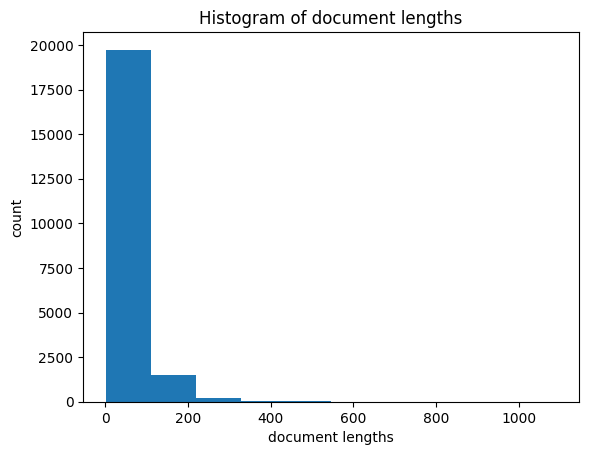

2023-11-10 00:02:59,586:INFO:tmtoolkit:processing vocabulary counts
INFO:tmtoolkit:processing vocabulary counts
2023-11-10 00:02:59,960:INFO:tmtoolkit:producing plot
INFO:tmtoolkit:producing plot


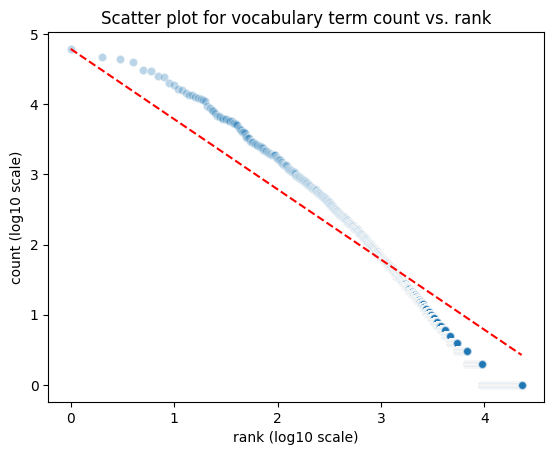

In [10]:
# Import necessary modules from tmtoolkit for preprocessing and visualization
from tmtoolkit.corpus import doc_tokens, tokens_table, vocabulary_counts
from tmtoolkit.corpus import to_lowercase, remove_punctuation, lemmatize
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_ranked_vocab_counts

# Transform tokens to lowercase
to_lowercase(corpus)

# Remove punctuation from tokens
remove_punctuation(corpus)

# Lemmatize tokens to get their base form
lemmatize(corpus)

# Now the corpus is preprocessed, we can visualize some statistics about it

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Plot the distribution of document lengths (number of tokens per document)
fig, ax = plt.subplots()
plot_doc_lengths_hist(fig, ax, corpus, y_log=False)  # Use linear scale on y-axis
plt.show()

# Plot the ranked vocabulary counts (token frequencies)
fig, ax = plt.subplots()
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)  # Compare with Zipf's law
plt.show()

Zipf's law is an empirical law that suggests a specific distribution of term frequencies in natural language texts. According to Zipf's law, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, and so on.

When you plot ranked vocabulary counts (token frequencies) in a log-log plot, with the ranks on the x-axis and the actual frequencies on the y-axis, Zipf's law predicts a roughly linear relationship. If a corpus follows Zipf's law, you would expect to see a straight line descending from the top-left to the bottom-right of the plot.

Here's what to look for when comparing your corpus with Zipf's law using `plot_ranked_vocab_counts` with the `zipf=True` parameter:

1. **Straight Line on Log-Log Plot**:
   - A straight line on a log-log plot of rank versus frequency indicates that the data follows a power-law distribution, which is consistent with Zipf's law.

2. **Slope of the Line**:
   - The slope of the line in a Zipfian distribution is typically close to -1. Deviations from this slope can indicate that the distribution of word frequencies in your corpus does not perfectly follow Zipf's law.

3. **High-Frequency Words**:
   - The most common words (e.g., "the", "of", "and") should appear at the top-left of the plot, indicating high frequency and low rank.

4. **Long Tail of Low-Frequency Words**:
   - There should be a "long tail" of words that appear infrequently in the corpus. These words will be positioned towards the bottom-right of the plot.

5. **Anomalies or Deviations**:
   - Any significant deviations from the straight line could indicate interesting linguistic features of your corpus. For example, a corpus with a lot of technical jargon or domain-specific language might not follow Zipf's law as closely as a corpus of general English.

It's important to note that while many natural language corpora approximately follow Zipf's law, there are often deviations, especially for smaller corpora or those with specialized vocabulary. The `plot_ranked_vocab_counts` function with `zipf=True` is a tool to help you visualize how closely your corpus follows this law and to identify any interesting patterns or anomalies in your data.

In [11]:
corpus[9]['token'][0:15]

['when',
 'it',
 'arrive',
 ',',
 'it',
 'have',
 'a',
 'dead',
 'battery',
 '--',
 'so',
 ',',
 'I',
 'have',
 'to']

We will also now generate two DTMs. Don't remember what a document term matrix is? Go back to the conceptual lecture and refresh!

Let's break down the concepts of document frequency and how the functions `filter_tokens_by_doc_frequency`, `remove_common_tokens`, and `remove_uncommon_tokens` work, along with some examples and heuristic thresholds from academic literature.

Document Frequency (DF)
Document frequency refers to the number of documents in a corpus that contain a specific token (word). For example, if you have a corpus of 100 documents and the word "shoe" appears in 90 of them, the document frequency of "shoe" is 90.

Filtering Tokens by Document Frequency
The function `filter_tokens_by_doc_frequency` allows you to filter out tokens based on how frequently they appear across documents. You can set a threshold to remove tokens that are either too common or too uncommon.

Examples:
1. **Removing Common Tokens**: If you set `df_threshold=0.9`, this means you want to remove tokens that appear in 90% or more of the documents. In our example, "shoe" would be removed because it appears in 90 out of 100 documents.

2. **Removing Uncommon Tokens**: Conversely, if you set `df_threshold=0.1`, you would remove tokens that appear in 10% or fewer of the documents. If "sneaker" appears in only 5 out of 100 documents, it would be removed.

Heuristic Thresholds
In academic literature, there is no one-size-fits-all threshold for document frequency filtering because the optimal threshold can vary depending on the corpus and the goals of the analysis. However, some common heuristics are:

- **Common Tokens**: A threshold of 0.95 to 0.99 is often used to remove extremely common tokens that may not be informative (e.g., stopwords).
- **Uncommon Tokens**: A threshold of 0.01 to 0.05 can be used to remove rare tokens that may be typos, very specific names, or otherwise not useful for broad analysis.

Academic Literature References
- In "Text Mining: Applications and Theory" by Michael W. Berry and Jacob Kogan, thresholds are discussed in the context of term weighting and feature selection.
- "Introduction to Information Retrieval" by Christopher D. Manning, Prabhakar Raghavan, and Hinrich Schütze provides a comprehensive overview of document frequency and its role in information retrieval.

Proportions vs. Absolute Counts
The `df_threshold` parameter can be set as a proportion (e.g., 0.1 for 10%) or as an absolute count (e.g., 10 documents). The choice between using proportions or absolute counts depends on the size of your corpus and your specific use case.

In [12]:
from copy import copy
from tmtoolkit.corpus import filter_clean_tokens, remove_common_tokens, remove_uncommon_tokens
from tmtoolkit.corpus import numbers_to_magnitudes

corp_bigger = copy(corpus)
to_lowercase(corp_bigger)

numbers_to_magnitudes(corp_bigger)
table_norm_num = tokens_table(corp_bigger, with_attr='like_num')
table_norm_num[table_norm_num.like_num]

filter_clean_tokens(corp_bigger, remove_shorter_than=2)

remove_common_tokens(corp_bigger, df_threshold=0.98)
remove_uncommon_tokens(corp_bigger, df_threshold=0.0005)

print_summary(corp_bigger)

2023-11-10 00:03:00,521:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2023-11-10 00:03:00,525:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2023-11-10 00:03:03,413:INFO:tmtoolkit:replacing 5418 token hashes
INFO:tmtoolkit:replacing 5418 token hashes
2023-11-10 00:03:04,016:INFO:tmtoolkit:replacing 545 token hashes
INFO:tmtoolkit:replacing 545 token hashes
2023-11-10 00:03:11,831:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 421348
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 421348
2023-11-10 00:03:15,899:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 421348
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 421348
2023-11-10 00:03:18,165:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 388076
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 42134

Corpus with 21569 documents in English
> reviews-B0000V9K3W.A5RZS69KSJH00 (12 tokens): watch exactly order get fast unfortunately bit big...
> reviews-B0000V9K32.ACT5DY536GISV (13 tokens): colour receive blue show yellow change birthday pr...
> reviews-B0000V9KRI.A1EDPEDXSQ78G4 (11 tokens): love watch use day work gym pool sport etc time go...
> reviews-B0000V9KNM.A2EAKTCKFRF7A4 (10 tokens): nike make anymore love watch lot compliment questi...
> reviews-B0000V9KRI.AR7L2ZP173QEE (12 tokens): good price good material excellent design useful t...
> reviews-B0000V9K32.A3BVWMS9I8OH8U (10 tokens): cute practical fit well small wrist case wear love...
> reviews-B0000V9KRS.A2RBU58FQTO2MV (9 tokens): totally love watch nice beautiful think buy fair p...
> reviews-B0000V9K46.A3F8O512N9UNVM (6 tokens): product come promptly describe pleasure business
> reviews-B0000V9KRI.A1BEBWGPSB2DLM (8 tokens): mean rock kinda dissapointe material lil bit cheap
> reviews-B0000V9KRS.A1UY8BIKG0VR12 (15 tokens):

In [13]:
from tmtoolkit.corpus import vocabulary_size

vocabulary_size(corpus), vocabulary_size(corp_bigger)

(22901, 2386)

Another copy of corp will apply more aggressive cleaning and hence will result in a smaller vocabulary size:

In [14]:
corp_smaller = copy(corpus)
to_lowercase(corp_smaller)

numbers_to_magnitudes(corp_smaller)
table_norm_num = tokens_table(corp_smaller, with_attr='like_num')
table_norm_num[table_norm_num.like_num]

filter_clean_tokens(corp_smaller, remove_shorter_than=2)

remove_common_tokens(corp_smaller, df_threshold=0.8)
remove_uncommon_tokens(corp_smaller, df_threshold=0.005)

print_summary(corp_smaller)

2023-11-10 00:03:19,966:INFO:tmtoolkit:creating Corpus instance with no documents
INFO:tmtoolkit:creating Corpus instance with no documents
2023-11-10 00:03:19,971:INFO:tmtoolkit:using serial processing
INFO:tmtoolkit:using serial processing
2023-11-10 00:03:23,842:INFO:tmtoolkit:replacing 5418 token hashes
INFO:tmtoolkit:replacing 5418 token hashes
2023-11-10 00:03:24,831:INFO:tmtoolkit:replacing 545 token hashes
INFO:tmtoolkit:replacing 545 token hashes
2023-11-10 00:03:31,995:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 421348
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 1125385 and is now 421348
2023-11-10 00:03:34,477:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 421348
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 421348
2023-11-10 00:03:37,126:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 421348 and is now 320181
INFO:tmtoolkit:filtered tokens by mask: num. tokens was 42134

Corpus with 21569 documents in English
> reviews-B0000V9K3W.A5RZS69KSJH00 (11 tokens): watch exactly order get fast unfortunately bit big...
> reviews-B0000V9K32.ACT5DY536GISV (12 tokens): receive blue show yellow change birthday present d...
> reviews-B0000V9KRI.A1EDPEDXSQ78G4 (10 tokens): love watch use day work gym sport etc time good
> reviews-B0000V9KNM.A2EAKTCKFRF7A4 (8 tokens): nike make love watch lot compliment people like
> reviews-B0000V9KRI.AR7L2ZP173QEE (10 tokens): good price good material excellent design totally ...
> reviews-B0000V9K32.A3BVWMS9I8OH8U (9 tokens): cute fit well small wrist case wear love watch
> reviews-B0000V9KRS.A2RBU58FQTO2MV (8 tokens): totally love watch nice beautiful think buy price
> reviews-B0000V9K46.A3F8O512N9UNVM (3 tokens): product come describe
> reviews-B0000V9KRI.A1BEBWGPSB2DLM (5 tokens): mean rock material bit cheap
> reviews-B0000V9KRS.A1UY8BIKG0VR12 (11 tokens): arrive battery new battery watch order wear watch ...
(and 21559 more doc

In [15]:
from tmtoolkit.corpus import vocabulary_size

vocabulary_size(corp_bigger), vocabulary_size(corp_smaller)

(2386, 506)

In [16]:
from tmtoolkit.corpus import dtm

dtm_bg, doc_labels_bg, vocab_bg = dtm(corp_bigger, return_doc_labels=True, return_vocab=True)
dtm_sm, doc_labels_sm, vocab_sm = dtm(corp_smaller, return_doc_labels=True, return_vocab=True)

dtm_bg, dtm_sm

2023-11-10 00:03:40,190:INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 2386
INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 2386
2023-11-10 00:03:56,298:INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 506
INFO:tmtoolkit:generating sparse DTM with 21569 documents and vocab size 506


(<21569x2386 sparse matrix of type '<class 'numpy.int32'>'
 	with 333877 stored elements in Compressed Sparse Row format>,
 <21569x506 sparse matrix of type '<class 'numpy.int32'>'
 	with 270920 stored elements in Compressed Sparse Row format>)

In [17]:
pickle.dump(doc_labels_bg, open('%s/doc_labels_bg.p' % working_directory, 'wb'))
pickle.dump(doc_labels_sm, open('%s/doc_labels_sm.p' % working_directory, 'wb'))

scipy.sparse.save_npz('%s/small_dtm.npz' % working_directory, dtm_sm)
scipy.sparse.save_npz('%s/big_dtm.npz' % working_directory, dtm_bg)

pickle.dump(vocab_bg, open('%s/big_vocab.p' % working_directory, 'wb'))
pickle.dump(vocab_sm, open('%s/small_vocab.p' % working_directory, 'wb'))

pickle.dump(corpus, open('%s/corpus.p' % working_directory, 'wb') )